# Assignment 2:
    Test the difference between a Binomial/Poisson distribution and a Gaussian distribution as you change the parameters of the Binomial/Poisson. Use: 
    
    1) Kolmogorov-Smirnov
    
    2) KL or Chisq
    
    3) Anderson
    
    6 test total (8 if you are ambitious and want to try Pearson's chisq)
    
    I want you to use the scipy.stats package for this. it will provide tests. For KS and AD you will simply need to generate the distribution the normal will be tested agains: the KS and AD functions in scipy have functionality to test against standard distributions (normal, chisq etc) without you having to code up anything about the distribution itself. KL and chisq do not. I am showing you how to do the AD, KS and KL for binomial, you can replicate it for the poisson or do the Chisq instead of KL.
    
    Even if you just replicate it... PLEASE UNDESRTAND IT! or you will have learned nothing and wasted both of our times

In [1]:
import pylab as pl
import pandas as pd
import numpy as np
%pylab inline
import os
import json
s = json.load( open(os.getenv ('PUI2015')+"/fbb_matplotlibrc.json") )
pl.rcParams.update(s)
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


Here are the manual pages fo the tests

http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.anderson.html#scipy.stats.anderson
http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html#scipy.stats.entropy

I need to figure out what each test function returns. let me run them once to see (and read the manual atthe same time!)

I am testing for normal against normal and for a binomial w small n*p against normal. that will give me very different outcomes.


In [2]:
#generate the distribution
np.random.seed(2015)
dist_n = np.random.randn(1000)

#test ad and ks. those are easy
print "normal on normal", scipy.stats.kstest(dist_n,'norm')
print "normal on normal", scipy.stats.anderson(dist_n, dist='norm')
print "" 

dist_b = np.random.binomial(1, 0.5, 1000)

print "poisson on normal", scipy.stats.kstest(dist_b,'norm')
print "poisson on normal", scipy.stats.anderson(dist_b, dist='norm')

threshold = scipy.stats.anderson(dist_n, dist='norm')[1][scipy.stats.anderson(dist_n, dist='norm')[2]==[1.0]]
print threshold

##what is this threshold I am saving??

normal on normal KstestResult(statistic=0.01890424961517756, pvalue=0.86717598486321534)
normal on normal AndersonResult(statistic=0.3511409513378112, critical_values=array([ 0.574,  0.653,  0.784,  0.914,  1.088]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

poisson on normal KstestResult(statistic=0.5, pvalue=0.0)
poisson on normal AndersonResult(statistic=179.53747488153613, critical_values=array([ 0.574,  0.653,  0.784,  0.914,  1.088]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))
[ 1.088]


### My Comments:

The threshold 1.088 is the critical value for a 1% level of confidence. This means that the Anderson-Darling test does not reject the null hypothesis for any of the listed confidence levels in the case where a normal sample is compared to the normal distribution, and that it rejects it for every confidence level below 1% when a Poisson sample is compared to the normal distribution.

The statistics value will be **larger** if the distributions are **not** likely to be related. 
think about this in terms of rejection of the NULL hypothesis. 

# Try writing down the null for each test and see if scipy manual agrees with you         (the manual spells out the Null)

- Null Hypothesis for KS: 2 sample distributions are from the same distribution

- Null Hypothesis for AD: a sample is drawn from a population that follows a particular distribution

the KL divergence is a little trickier: i have to pass it the values of the distribution at some x's: that means i have to pass it a **NORMALIZED HOSTOGRAM OF MY DISTRIBUTION**, i.e. derive a PDF from the data. we have done it before!

i have to pass it a function for my comparison distribution evaluated at the x-values where my empirical distribution is evaluated.  not just the name of a distribution

In [3]:
distpdf_n, mybins_n, = np.histogram(dist_n, density=True)
distpdf_b, mybins_b, = np.histogram(dist_b, density=True)
#notice the extra comma on the left side of the '=' sign: that tells numpy take the first two values returned, and throw away the rest

then i have to pass it the functional form of a normal PDF, which is returned by the function scipy.stats.norm for example (a google search would have told you!) 
evaluated at the bin centers of the histogram from before

In [4]:
#get the bin centers
bincenters_n = mybins_n[:-1] + 0.5*(mybins_n[1] - mybins_n[0])
bincenters_b = mybins_b[:-1] + 0.5*(mybins_b[1] - mybins_b[0])
print "normal on normal", scipy.stats.entropy(distpdf_n, scipy.stats.norm.pdf(bincenters_n))  
print "poisson on normal", scipy.stats.entropy(distpdf_b, scipy.stats.norm.pdf(bincenters_b)) 

#you can interpret this as a distance: it increases as the distributions diverge

normal on normal 0.00480162817937
poisson on normal 1.68378761755


So it looks like a high value is rejecting the NULL that the result from different distributions is larger than similiar models.

# BINOMIAL

In [5]:
#to store the data i am generating an empty array of the size of the values of n i want to test. i do that with np.zeros which takes the length of the array as argument, and the data type as optional argument, but default is float, which is fine by me, so i do not need any argument other then the lenght 
narray = range(1,50,1)
ks_b = np.zeros(len(narray))
ad_b = np.zeros(len(narray))
kl_b = np.zeros(len(narray))
chi2_b = np.zeros(len(narray))


def mynorm (x, mu, var):
    return scipy.stats.norm.cdf(x, loc=mu, scale=var)

#then i put the tests in a for loop so that i can generate a distribution for given parameters once, 
#and run all tests against it
#now the valus that i want to plot depends on how i intend to describe the plot, and viceversa. 

#here is one way to plot it, knowing the values i get for the tests when 
#i throw in a poisson distribution with low l and compare it with a gaussian and 
#assuming that that is a vary bad match
p=0.5
for i,n in enumerate(narray):
    p=0.1 #parameter for the binomial, my arbitrary choice
    #generate the distribution
    dist = np.random.binomial(n, p, 1000)
    #run the tests. 
 
    ks_b[i] = scipy.stats.kstest(dist, mynorm, args=(n*p, n*p*(1.0-p)))[0]
    ad_b[i] = scipy.stats.anderson(dist, dist='norm')[0]
    
    
    # for KL and Pearson's chisq I have to simulate the normal distribution as well
    mybins=np.linspace(min(dist),max(dist), 10) 
    bincenters = mybins[:-1]+0.5*(mybins[1]-mybins[0])

    #when i was coding this up something was wrong. i put some plots in to figure out what... just so you know.
    #if i%10 == 0: 
    #    print n
    #    pl.figure()
    #    pl.hist(dist, bins=mybins)
    #    pl.plot(bincenters, 1000*scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1-p)))
    kl_b [i] =  scipy.stats.entropy(np.histogram(dist, bins=mybins)[0], scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1.0-p)))
    

# This is just one way to plot it. get creative and find the best way to show your result!
then give me a cell in which you write a caption for the figures you plot. think about how the captions are written in the paper  you have to read for this week assignment: a caption must describe the plot sufficiently well that i do not need to read the paper to understand it. though it will generally lack details of the how and why you see what you see. those are in the paper

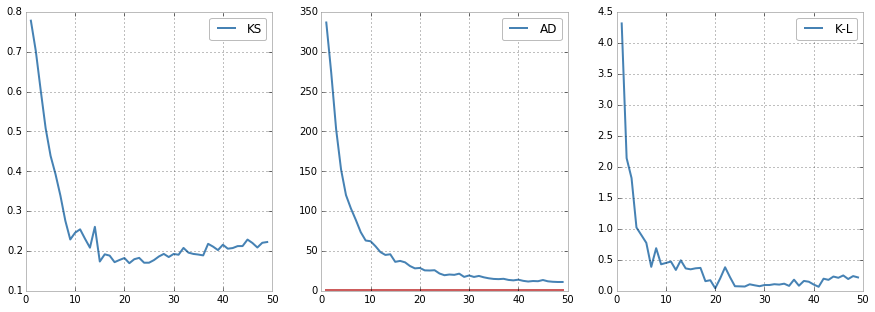

In [6]:

fig = pl.figure(figsize = (15,5))
fig.add_subplot(131)
pl.plot(narray, ks_b, label='KS')
pl.legend()

fig.add_subplot(132)
pl.plot(narray, ad_b,  label='AD')
pl.plot([narray[0], narray[-1]],[threshold, threshold])
pl.plot()
pl.plot()
pl.legend()

fig.add_subplot(133)
pl.plot(narray, kl_b, label='K-L ')

pl.legend()

# POISSON

In [7]:


#to store the data i am generating an empty array of the size of the values of n i want to test. i do that with np.zeros which takes the length of the array as argument, and the data type as optional argument, but default is float, which is fine by me, so i do not need any argument other then the lenght 
narray = range(1,50,1)
ks_b = np.zeros(len(narray))
ad_b = np.zeros(len(narray))
kl_b = np.zeros(len(narray))
chi2_b = np.zeros(len(narray))


#then i put the tests in a for loop so that i can generate a distribution for given parameters once, 
#and run all tests against it
#now the valus that i want to plot depends on how i intend to describe the plot, and viceversa. 

#here is one way to plot it, knowing the values i get for the tests when 
#i throw in a poisson distribution with low l and compare it with a gaussian and 
#assuming that that is a vary bad match

for i,n in enumerate(narray):
    p=0.1 #parameter for the binomial, my arbitrary choice
    #generate the distribution
    dist = np.random.poisson(n, 1000)
    #run the tests. 
    ks_b[i] = scipy.stats.kstest(dist, mynorm, args=(n, n))[0]
    ad_b[i] = scipy.stats.anderson(dist, dist='norm')[0]
    
        
    # for KL and Pearson's chisq I have to simulate the normal distribution as well
    mybins = np.linspace(min(dist),max(dist), 10) 
    bincenters = mybins[:-1]+0.5*(mybins[1]-mybins[0])
 
    kl_b [i] =  scipy.stats.entropy(np.histogram(dist, bins=mybins)[0], scipy.stats.norm.pdf(bincenters, loc=n*p, scale=n*p*(1.0-p)))
    

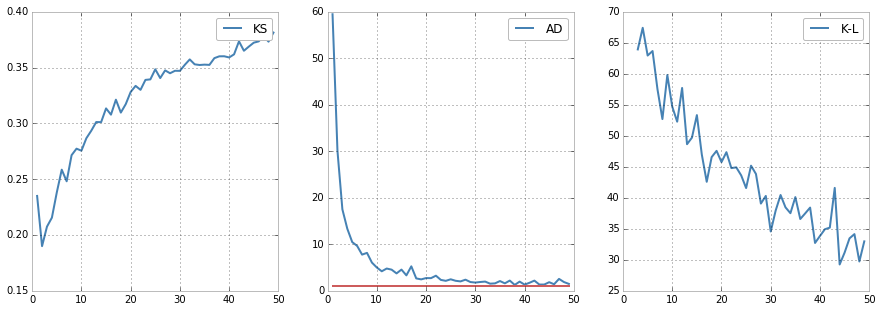

In [8]:

fig = pl.figure(figsize = (15,5))
fig.add_subplot(131)
pl.plot(narray, ks_b, label='KS')
pl.legend()

fig.add_subplot(132)
pl.plot(narray, ad_b,  label='AD')
pl.plot([narray[0], narray[-1]],[threshold, threshold])
pl.plot()
pl.plot()
pl.legend()

fig.add_subplot(133)
pl.plot(narray, kl_b, label='K-L ')

pl.legend()

## TOTALLY OPTIONAL fun with KL: the KL divergence is a measure of how much approximation you have to do to represent one distribution with the other. you can see what it looks point by point, before you integrate and get a single distance number

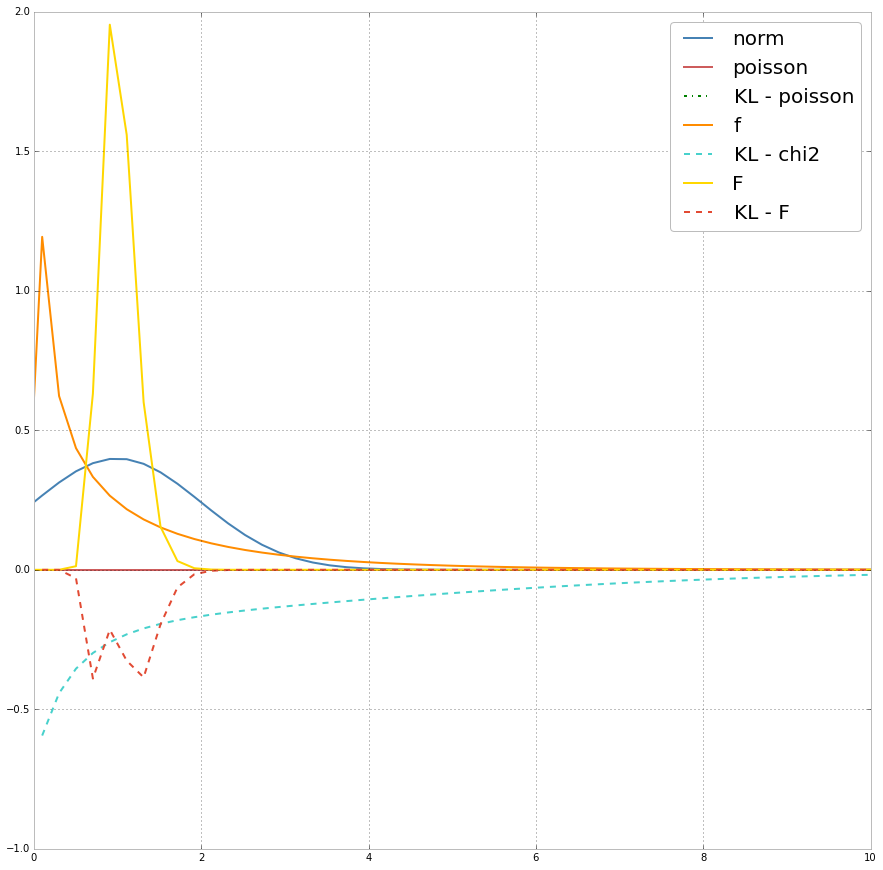

In [9]:
pl.figure(figsize=(15,15))

p = lambda x, mu : scipy.stats.distributions.poisson.pmf(x,mu)
q = lambda x, mu : scipy.stats.distributions.norm.pdf(x-mu)
c = lambda x, mu : scipy.stats.distributions.chi2.pdf(x, df=mu)
f = lambda x, mu : scipy.stats.distributions.f.pdf(x,100,100)

Dkl = lambda x ,mu, p :  p(x, mu)* np.log10(q(x, mu)) + p(x, mu) *np.log10(p(x, mu))

def model(x) : 
    return 1./(s*np.sqrt(2*np.pi))*exp(-((x-m)/2./2./s)**2)

x=np.linspace(-10,10,100)
pl.plot(x, q(x,1), label='norm')
pl.plot(x, p(x,1), label='poisson')
pl.plot(x, Dkl(x, 1, p), '-.', label = 'KL - poisson')

#print np.nansum(Dkl(np.linspace(0,30,1000), 1, p))


pl.plot(x, c(x,1), label='f')
pl.plot(x,Dkl(x, 1, c), '--', label = 'KL - chi2')



#print np.nansum(Dkl(np.linspace(0,30,1000), 1, c))


pl.plot(x, f(x,1), label='F')
pl.plot(x,Dkl(x, 1, f), '--', label = 'KL - F')

#print np.nansum(Dkl(np.linspace(0,30,1000), 1, f))
bins = np.arange(0, 99, 10)

pl.xlim(0,10)
pl.legend( fontsize = 20)

##WRITE A CAPTION HERE IN THIS CELL..